In [1]:
import skimage.io as io

# Show the figures / plots inside the notebook
%matplotlib inline
from skimage.color import rgb2gray,rgb2hsv, rgba2rgb
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.util import random_noise
import numpy as np
from commonfunctions import *
from skimage import io, color, morphology
from skimage.measure import label, regionprops
from skimage.draw import polygon
from skimage import transform
from skimage.morphology import binary_closing
from scipy import ndimage

from skimage.exposure import histogram
from matplotlib.pyplot import bar

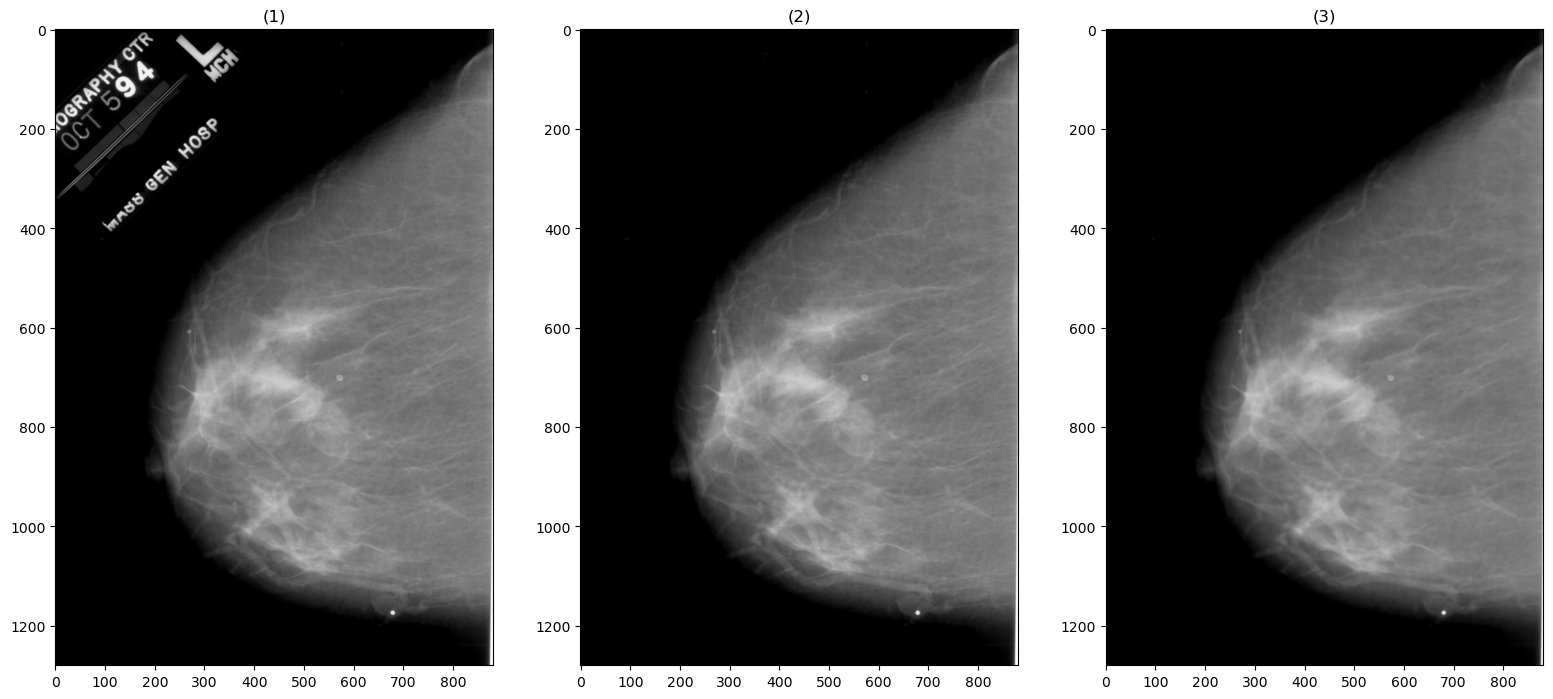

In [3]:
#image = io.imread("D:\image processing\Project\Breast-Cancer-Detection-IP\images\WhatsApp Image 2025-11-06 at 17.46.17_ea76d16f.jpg")
image = io.imread("images\WhatsApp Image 2025-11-06 at 17.46.17_ea76d16f.jpg")

img_gray = color.rgb2gray(image)
binary_img = img_gray > 0.3

top_crop = 410   # Height of label area
left_crop = 370  # Width of label area

# Create cleaned image by replacing top-left with background
cleaned_image = img_gray.copy()
cleaned_image[:top_crop, :left_crop] = 0  # Fill with black

filtered_image = ndimage.median_filter(cleaned_image, size=5)

show_images([image,cleaned_image,filtered_image])

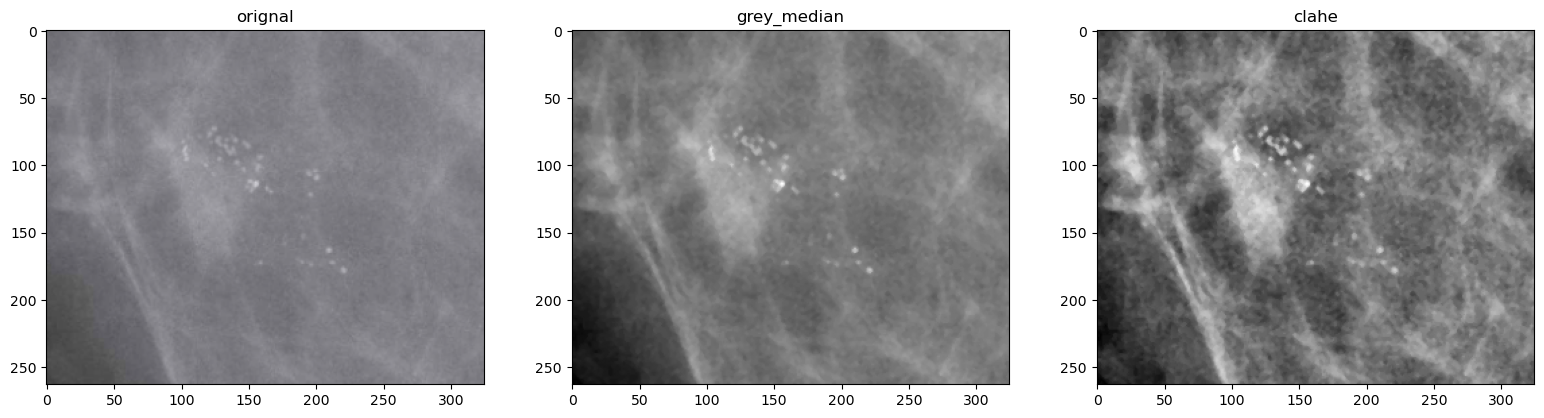

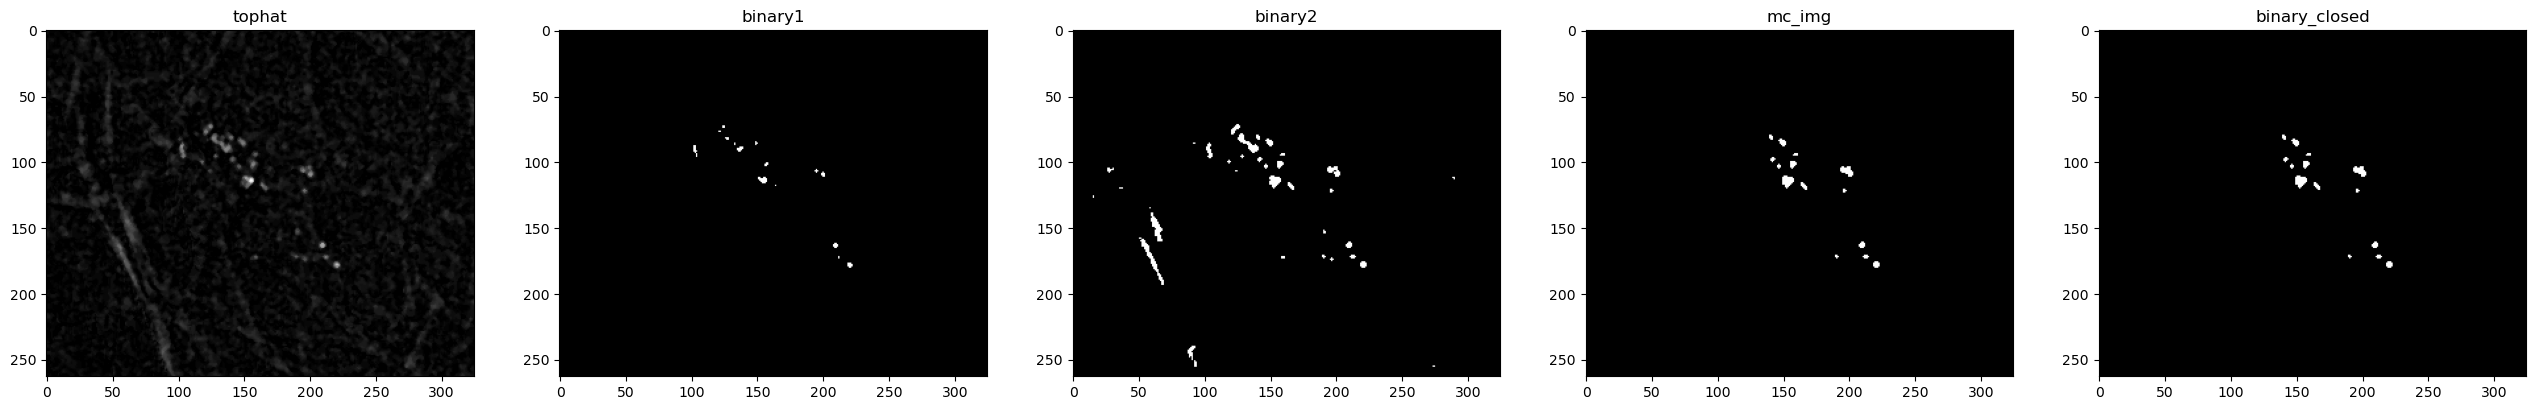

In [ ]:

original = io.imread("images\image1.png")
#original = io.imread("images\image2.png")
img = rgba2rgb(original)
img = rgb2gray(img)

# Convert to uint8 (0-255) for OpenCV
img = (img * 255).astype(np.uint8)

# Apply median blur
img = cv2.medianBlur(img, 3)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clahe_img = clahe.apply(img)


# Structuring element (tune size depending on MC size)
#~10–20 pixels 
#5x5 Background is not removed properly → noisy image
#30x30 Some micro-calcifications may get removed
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (12, 12))

#openning erosion -> dilation removes bright structures smaller than the kernel
eroded = cv2.erode(img, kernel, iterations=1)

opened = cv2.dilate(eroded, kernel, iterations=1)

#tophat original - opened (gets the small  bright structures)
tophat = cv2.subtract(img, opened)



# Normalize to 0-255
tophat_norm = cv2.normalize(tophat, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

#convert to binary
_, binary1 = cv2.threshold(tophat, 25, 255, cv2.THRESH_BINARY)

# Compute histogram
hist = cv2.calcHist([tophat_norm], [0], None, [256], [0,256])

total_pixels = tophat_norm.size
cumsum = np.cumsum(hist)
#pixel intensity where 99% of pixels are below it
threshold_idx = np.searchsorted(cumsum, total_pixels*0.99)
_, binary2 = cv2.threshold(tophat_norm, threshold_idx, 255, cv2.THRESH_BINARY)

kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
binary_closed = cv2.morphologyEx(binary2, cv2.MORPH_CLOSE, kernel_close)



contours, _ = cv2.findContours(binary_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mc_contours = []
for cnt in contours:
    area = cv2.contourArea(cnt)
    if 2 < area < 50:  # MCs are tiny
        perimeter = cv2.arcLength(cnt, True)
        if perimeter == 0:
            continue
        circularity = 4*np.pi*(area/(perimeter**2))
        if 0.5 < circularity < 1.2:
            mc_contours.append(cnt)

mc_img = np.zeros_like(binary2)
cv2.drawContours(mc_img, mc_contours, -1, 255, -1)

mc_img_closed = np.zeros_like(binary_closed)
cv2.drawContours(mc_img_closed, mc_contours, -1, 255, -1)





show_images([original, img, clahe_img],["orignal", "grey_median", "clahe"])
show_images([tophat, binary1, binary2, mc_img, mc_img_closed],["tophat", "binary1", "binary2", "mc_img", "binary_closed"])


In [ ]:
pip install opencv-python
